# First look at data and basic duplicate removal

#### Import Libraries

In [694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from itertools import combinations

from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KernelDensity

from sklearn.metrics.pairwise import linear_kernel

import re
from collections import Counter

import sys
import time

import networkx as nx




from nltk.corpus import stopwords, reuters
from nltk import FreqDist

#### Load data

In [940]:
jobs_df = pd.read_csv("jobs_data.csv")

#### Count missing values

In [941]:
jobs_df.isna().sum()

title                 0
company_name          0
location              1
via                   0
description           0
job_id                0
thumbnail          1501
posted_at             0
schedule_type        90
work_from_home     3155
search_term           0
date_time             0
search_location       0
extensions            0
dtype: int64

#### Drop collumns with missing values

In [942]:
# Drop columns with many missing values
jobs_df = jobs_df.drop(columns=["thumbnail", "work_from_home"])


## Drop jobs collected during testing
When setting up the Google Cloud Functions I forced the function to run a couple times to test if it works.<br>
This resulted in jobs being collected when I forced the function to run and when it was scheduled.<br>

In [698]:
# Convert 'date_time' to datetime format
jobs_df['date_time'] = pd.to_datetime(jobs_df['date_time'])

# Let's look at the times when the data was collected:
jobs_df['date_time'].dt.hour.value_counts()

# Number of rows to be removed
num_rows = len(jobs_df[jobs_df['date_time'].dt.hour != 22])

# Drop the results where the hour is not 22
jobs_df = jobs_df[jobs_df['date_time'].dt.hour == 22]

# Print num of rows dropped:
print(f"Dropped {num_rows} rows")

Dropped 322 rows


## Duplicate jobs based on different parameters

Matching job_id

Matching title, company and description


### Matching: job_id

In [699]:
# Filter rows with duplicated 'job_id'
duplicated_jobs_df = jobs_df[jobs_df.duplicated(subset='job_id', keep=False)]

# Count the number of unique duplicated 'job_id's (groups)
count_unique_job_ids = duplicated_jobs_df['job_id'].nunique()

# Count the total number of jobs in these groups
count_duplicated_jobs = len(duplicated_jobs_df)

print("Number of duplicate job_id groups:", count_unique_job_ids)
print("Number of jobs which fall into these groups:", count_duplicated_jobs)


Number of duplicate job_id groups: 153
Number of jobs which fall into these groups: 332


#### Check if job titles match up where job_id matches

In [943]:
# Filter rows where a 'job_id' is associated with multiple 'title's
differing_titles_df = jobs_df.groupby('job_id').filter(lambda group: group['title'].nunique() > 1)


print("Number of job_id groups with differing titles:", differing_titles_df['job_id'].nunique())
print("Number of jobs which fall into these groups:", len(differing_titles_df))



Number of job_id groups with differing titles: 0
Number of jobs which fall into these groups: 0


It appears that if the job_id is the same, then so are the titles. This is a good sign, we can safely delete duplicates on job_id.

#### Sort the dataframe on date ascending
When deleting duplicates, I want to keep the chronologically first occurance.

In [701]:
jobs_df = jobs_df.sort_values(by='date_time', ascending=True)
jobs_df.reset_index(inplace=True)
jobs_df.drop(columns="index", inplace=True)

#### Drop jobs with matching job_id

In [702]:
# Drop duplicates, keeping the first occurrence of each duplicate

# Store the original number of rows
original_num_rows = len(jobs_df)

# Drop duplicates
jobs_df = jobs_df.drop_duplicates(subset='job_id', keep='first')

# Calculate the number of rows dropped
num_rows_to_delete = original_num_rows - len(jobs_df)

print(f"Dropped {num_rows_to_delete} rows")

Dropped 179 rows


### Matching title, company and description

In [703]:
same_title_company_description_df = jobs_df.groupby(['title', 'company_name','description']).filter(lambda group: group['job_id'].nunique() > 1)
count_unique_pairs = len(same_title_company_description_df.groupby(['title', 'company_name','description']))
count_jobs = len(same_title_company_description_df)


print("Number of duplicate groups:", count_unique_pairs)
print("Number of jobs which fall into these groups:", count_jobs)



Number of duplicate groups: 423
Number of jobs which fall into these groups: 1044


#### Drop jobs with matching title, company and description

In [704]:
# Store the original number of rows
original_num_rows = len(jobs_df)

# Drop duplicates based on the combination of 'title', 'company_name', and 'description', while keeping the first occurrence of each duplicate
jobs_df = jobs_df.drop_duplicates(subset=['title', 'company_name', 'description'], keep='first')

# Calculate the number of rows dropped
num_rows_dropped = original_num_rows - len(jobs_df)

print(f"Dropped {num_rows_dropped} rows")


Dropped 621 rows


# Remove Duplicates based on similar descriptions 

### Matching title and company
While a match on title and company isn't sufficient to deduce that the jobs are duplicated, I will investigate jobs with similar descriptions and select an appropriate threshold for their similarity.

In [705]:
same_title_company_groupby = jobs_df.groupby(['title', 'company_name'])
grouped_counts = same_title_company_groupby.size()
n_duplicate_groups = sum(grouped_counts > 1)
duplicate_groups = grouped_counts[grouped_counts > 1]
n_duplicate_jobs = duplicate_groups.sum()

print(f"Number of duplicate job groups: {n_duplicate_groups}")
print(f"Number of duplicate jobs: {n_duplicate_jobs}")



Number of duplicate job groups: 284
Number of duplicate jobs: 679


#### Groups with most jobs

In [706]:

# Sorting the groups by the number of jobs in descending order
sorted_duplicate_groups = duplicate_groups.sort_values(ascending=False)

print("Groups with most jobs:")
display(sorted_duplicate_groups[0:10])


Groups with most jobs:


title                   company_name    
Data Analyst            Harnham             8
                        Xcede               6
Tender Data Analyst     EVERSANA            5
Marketing Data Analyst  Jobleads-UK         5
Data Analyst            myGwork             5
                        Boston Hale         5
                        Jobleads-UK         5
HR Data Analyst         Macmillan Davies    4
Data Analyst            Lorien              4
Senior Data Analyst     Data Idols          4
dtype: int64

## Different Similarity metrics

1. SequenceMatcher

2. Cosine Similarity with TF-IDF

3. Jaccard similarity


I will compare the three methods by plotting all the similarity scores between within-group and cross-group pairs of jobs. <br>
I expect to see two distinct groups in the distributions, pairs of job postings which are in fact the same jobs and those that aren't.



#### Generate within_group and out_of_group pairs of jobs 
withing_group_pairs ar those which match on title and company_name
out_of_group_pairs are those which don't match on title and/or company_name

I will only use the jobs which fall into some group of jobs with the same title and company name to speed up computation.

In [707]:
# select only the jobs which have at least one pair with the same title and company_name
same_title_company_df = jobs_df.groupby(['title', 'company_name',]).filter(lambda group: group['job_id'].nunique() > 1 and group['description'].nunique() > 1 )

# create groupby  
same_title_company_groupby = same_title_company_df.groupby(['title', 'company_name'])


print("Number of duplicate groups:", len(same_title_company_groupby))
print("Number of jobs which fall into these groups:", len(same_title_company_df))



Number of duplicate groups: 284
Number of jobs which fall into these groups: 679


#### Generate pairs of jobs matching in title and company_name and pairs that don't match

In [708]:
# Create a list of groups of jobs which match on title company_name
same_title_company_list = [group for _, group in same_title_company_groupby if len(group) > 1]

# Get all possible pairs of indices from the set of jobs which have at least one pair
all_pairs = list(combinations(same_title_company_df.index, 2))

# Convert the groups that do match to a set of pairs of indices
matching_pairs = set()
for group in same_title_company_list:
    for pair in combinations(group.index, 2):
        matching_pairs.add(pair)

# Get the pairs of indices that don't match
non_matching_pairs = set(all_pairs) - matching_pairs



## Calculate similarity scores 

### Define functions for similarity scores 

In [709]:
# Define similarity functions
def sequence_matcher_similarity(text1, text2):
    return SequenceMatcher(None, text1, text2).ratio()

def cosine_text_similarity(text1, text2):
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors[0:1], vectors[1:2])[0][0]

def jaccard_similarity(text1, text2):
    vectorizer = CountVectorizer(analyzer='word')
    texts = [text1, text2]
    transformation = vectorizer.fit_transform(texts).toarray()
    intersection = np.sum(np.minimum(transformation[0], transformation[1]))
    union = np.sum(np.maximum(transformation[0], transformation[1]))
    return 0 if union == 0 else intersection / float(union)

# Initialize similarity metrics
similarity_metrics = {
    'sequence': sequence_matcher_similarity,
    'cosine': cosine_text_similarity,
    'jaccard': jaccard_similarity  
}

# Function to compute within-group scores and job_ids
def within_group_scores(group, similarity_function):
    descriptions = group['description'].tolist()
    job_ids = group['job_id'].tolist()
    scores = [similarity_function(descriptions[i], descriptions[j]) 
              for i in range(len(descriptions)) for j in range(i+1, len(descriptions))]
    job_ids_pairs = [(job_ids[i], job_ids[j]) 
                     for i in range(len(job_ids)) for j in range(i+1, len(job_ids))]
    return scores, job_ids_pairs

# Function to compute cross-group scores and job_ids
def cross_group_scores(group1, group2, similarity_function):
    descriptions1 = group1['description'].tolist()
    job_ids1 = group1['job_id'].tolist()
    descriptions2 = group2['description'].tolist()
    job_ids2 = group2['job_id'].tolist()
    scores = [similarity_function(desc1, desc2) for desc1 in descriptions1 for desc2 in descriptions2]
    job_ids_pairs = [(id1, id2) for id1 in job_ids1 for id2 in job_ids2]
    return scores, job_ids_pairs

### Create data DataFrames dictionary (used for similarity scores)

In [710]:
# DataFrames dictionary
dfs = {}

#### calculate similarity scores for matching pairs

In [711]:


matching_indices = list(matching_pairs)
total_pairs = len(matching_pairs)

for metric_name, similarity_function in similarity_metrics.items():
    matching_scores_list = []
    
    start_time = time.time()  # Record the time before starting the loop
    
    # Calculate similarity scores for matching pairs
    for idx, pair in enumerate(list(matching_pairs)):
        row1 = same_title_company_df.loc[pair[0]]
        row2 = same_title_company_df.loc[pair[1]]

        description1, description2 = row1['description'], row2['description']
        
        score = similarity_function(description1, description2)
        
        matching_scores_list.append(score)
        
        elapsed_time = time.time() - start_time  # Calculate the time elapsed
        
        # Progress Indicator with Time Elapsed
        sys.stdout.write(f"\rCalculating {metric_name}: {idx+1}/{total_pairs} ({((idx+1)/total_pairs) * 100:.2f}%) | Time elapsed: {elapsed_time:.2f} seconds")
        sys.stdout.flush()
        
    print()  # New line after loop completes
    
    dfs[f"{metric_name}_matching"] = pd.DataFrame({
        'score': matching_scores_list,
        'index_1': [idx[0] for idx in matching_indices],
        'index_2': [idx[1] for idx in matching_indices]
    })


Calculating sequence: 557/557 (100.00%) | Time elapsed: 1.48 seconds
Calculating cosine: 557/557 (100.00%) | Time elapsed: 0.76 seconds
Calculating jaccard: 557/557 (100.00%) | Time elapsed: 0.46 seconds


#### calculate similarity scores for non-matching pairs

In [712]:
non_matching_indices = list(non_matching_pairs)
total_pairs = len(non_matching_pairs)

similarity_metrics = {
    'cosine': cosine_text_similarity,
    'jaccard': jaccard_similarity  
} ## omit sequence for now since it takes too much time

for metric_name, similarity_function in similarity_metrics.items():
    non_matching_scores_list = []

    start_time = time.time()  # Record the time before starting the loop

    for i, pair in enumerate(non_matching_indices):
        row1 = same_title_company_df.loc[pair[0]]
        row2 = same_title_company_df.loc[pair[1]]
        description1, description2 = row1['description'], row2['description']
        score = similarity_function(description1, description2)
        non_matching_scores_list.append(score)

        # Calculate the percentage completion
        percentage_done = ((i + 1) / total_pairs) * 100

        elapsed_time = time.time() - start_time  # Calculate the time elapsed

        # Write progress and time elapsed to stdout and flush it immediately
        sys.stdout.write(f"\rCalculating {metric_name}: {i + 1}/{total_pairs} ({percentage_done:.2f}%) | Time elapsed: {elapsed_time:.2f} seconds")
        sys.stdout.flush()

    print()  # New line after loop completes
    
    # Create DataFrame after loop
    dfs[f"{metric_name}_non_matching"] = pd.DataFrame({
        'score': non_matching_scores_list,
        'index_1': [idx[0] for idx in non_matching_indices],
        'index_2': [idx[1] for idx in non_matching_indices]
    })


Calculating cosine: 29/229624 (0.01%) | Time elapsed: 0.06 seconds

Calculating cosine: 229624/229624 (100.00%) | Time elapsed: 311.75 seconds
Calculating jaccard: 229624/229624 (100.00%) | Time elapsed: 215.93 seconds


### Plot and investigate similarity scores 

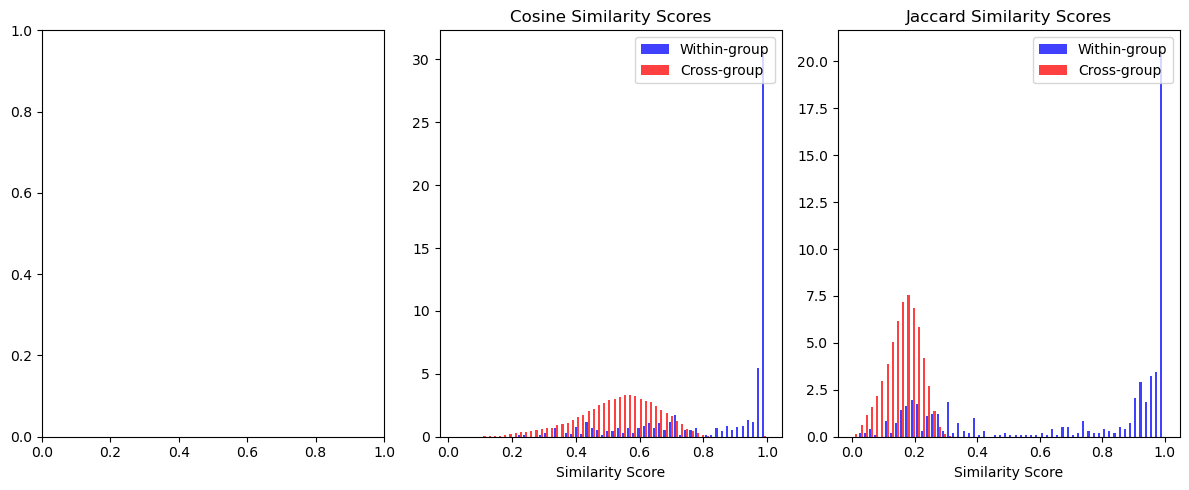

In [713]:
# Setting up the plotting area
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

"""
# Plotting SequenceMatcher scores 
ax[0].hist([dfs['sequence_matching'].score, dfs['sequence_non_matching'].score], bins=60, alpha=0.75, color=['blue', 'red'], label=['Within-group', 'Cross-group'], density=True)
ax[0].set_xlabel('Similarity Score')
ax[0].set_ylabel('Density')
ax[0].set_title('SequenceMatcher Similarity Scores')
ax[0].legend(loc='upper right')
"""

# Plotting Cosine Similarity scores 
ax[1].hist([dfs['cosine_matching'].score, dfs['cosine_non_matching'].score], bins=60, alpha=0.75, color=['blue', 'red'], label=['Within-group', 'Cross-group'], density=True)
ax[1].set_xlabel('Similarity Score')
ax[1].set_title('Cosine Similarity Scores')
ax[1].legend(loc='upper right')

# Plotting Jaccard Similarity scores
ax[2].hist([dfs['jaccard_matching'].score, dfs['jaccard_non_matching'].score], bins=60, alpha=0.75, color=['blue', 'red'], label=['Within-group', 'Cross-group'], density=True)
ax[2].set_xlabel('Similarity Score')
ax[2].set_title('Jaccard Similarity Scores')
ax[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [714]:
# Closer Look at jaccard similarity between 0.9 and 1.0

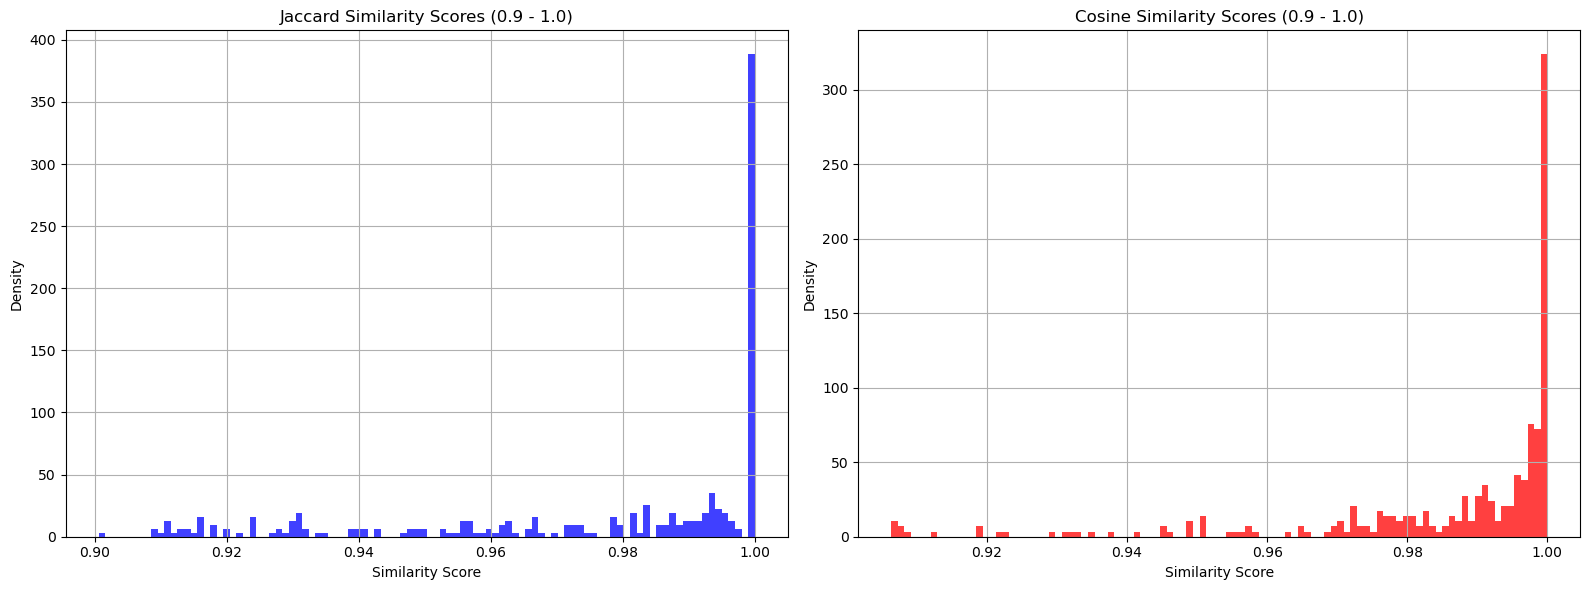

In [715]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Filter and plot the 'jaccard_matching' scores between 0.9 and 1.0
filtered_scores_jaccard = dfs['jaccard_matching']['score'][(dfs['jaccard_matching']['score'] >= 0.9) & (dfs['jaccard_matching']['score'] <= 1.0)]
axs[0].hist(filtered_scores_jaccard, bins=100, alpha=0.75, color='blue', density=True)
axs[0].set_xlabel('Similarity Score')
axs[0].set_ylabel('Density')
axs[0].set_title('Jaccard Similarity Scores (0.9 - 1.0)')
axs[0].grid(True)

# Filter and plot the 'cosine_matching' scores between 0.9 and 1.0
filtered_scores_cosine = dfs['cosine_matching']['score'][(dfs['cosine_matching']['score'] >= 0.9) & (dfs['cosine_matching']['score'] <= 1.0)]
axs[1].hist(filtered_scores_cosine, bins=100, alpha=0.75, color='red', density=True)
axs[1].set_xlabel('Similarity Score')
axs[1].set_ylabel('Density')
axs[1].set_title('Cosine Similarity Scores (0.9 - 1.0)')
axs[1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [716]:
import pandas as pd

subset_dfs = {k: dfs[k] for k in ('jaccard_matching', 'cosine_matching')}


thresholds = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]

ranges = [f"{thresholds[i]}-{thresholds[i+1]}" for i in range(len(thresholds) - 1)] + ['1.0']
data = {'Score Range': ranges}


for key in subset_dfs:
    df = dfs[key]
    total_rows = len(df)
    percentages = []
    for i in range(len(thresholds) - 1):
        lower_bound, upper_bound = thresholds[i], thresholds[i+1]
        count = len(df[(df['score'] >= lower_bound) & (df['score'] < upper_bound)])
        percentages.append(round((count / total_rows) * 100, 2))
    
    count_1_0 = len(df[df['score'] == 1.0])
    percentages.append(round((count_1_0 / total_rows) * 100, 2))
    
    data[f'{key}'] = percentages

perc_df = pd.DataFrame(data)
print(perc_df)


   Score Range  jaccard_matching  cosine_matching
0     0.9-0.91              0.72             1.08
1    0.91-0.92              3.59             0.54
2    0.92-0.93              2.51             0.54
3    0.93-0.94              2.15             0.90
4    0.94-0.95              1.97             1.26
5    0.95-0.96              3.23             1.80
6    0.96-0.97              3.23             1.08
7    0.97-0.98              3.41             6.46
8    0.98-0.99              5.92             6.64
9     0.99-1.0              8.08            30.16
10         1.0             21.90             5.21


## Remove jobs with similarity score above 0.99


### Clustering

In [717]:
# pairs of jobs with similarity score above 0.99 using jaccard similarity

pairs_df = dfs['jaccard_matching'][dfs['jaccard_matching']['score']>=0.99][['index_1','index_2']]
pairs_list = [tuple(row) for row in pairs_df.values]

# Sort each tuple in pairs_list (for comparison with edges)
sorted_pairs_list = [tuple(sorted(tpl)) for tpl in pairs_list]

# Convert list of sorted tuples to a set for easier comparison
unique_sorted_pairs = set(sorted_pairs_list)

G = nx.Graph()
G.add_edges_from(sorted_pairs_list)

num_duplicate_pairs = G.number_of_edges()

num_job_ids = G.number_of_nodes()

clusters = [list(c) for c in nx.connected_components(G)]

print(f"Number of clusters: {len(clusters)}")
print(f"Number of pairs: {num_duplicate_pairs}")
print(f"Number of distinct job_ids: {num_job_ids}")

counter = Counter([len(x) for x in clusters])
counter_values = counter.items()
counter_values

for size, count in sorted(counter_values, reverse=True):
    print(f"{count} clusters of size {size}")


Number of clusters: 141
Number of pairs: 167
Number of distinct job_ids: 295
13 clusters of size 3
128 clusters of size 2


### Remove rows based on similar descriptions , keeping one from each cluster

In [982]:
rows_to_remove = []


for cluster in clusters:
    sorted_cluster = sorted(cluster)  # Sort to find the smallest element
    rows_to_remove.extend(sorted_cluster[1:])  # Exclude the smallest one

cleaned_jobs_df = jobs_df.drop(rows_to_remove)

print(f"{len(rows_to_remove)} rows dropped")


308 rows dropped


#### Verify clusters (clean this up)

In [719]:
# Extract all nodes and edges from the graph
graph_nodes = set(G.nodes())
graph_edges = set(G.edges())

# Extract all unique numbers and pairs from pairs_list
unique_numbers = set([num for tpl in pairs_list for num in tpl])
unique_pairs = set(pairs_list)

# Check if all unique numbers are nodes in the graph
if graph_nodes == unique_numbers:
    print("All unique numbers are nodes in the graph.")
else:
    print("Some unique numbers are missing as nodes in the graph.")

All unique numbers are nodes in the graph.


In [720]:
# Extract all edges from the graph and sort them
graph_edges = set(tuple(sorted(edge)) for edge in G.edges())

# Compare unique_sorted_pairs and graph_edges
if graph_edges == unique_sorted_pairs:
    print("All sorted pairs are edges in the graph.")
else:
    missing_edges = unique_sorted_pairs - graph_edges
    print(f"Some sorted pairs are missing as edges in the graph. Missing edges: {missing_edges}")

All sorted pairs are edges in the graph.


In [721]:
# Graph Clustering (Here, using connected components as a simple example)
clusters = [list(c) for c in nx.connected_components(G)]

# Check if all nodes are in clusters
total_nodes_in_clusters = sum(len(cluster) for cluster in clusters)

if total_nodes_in_clusters == len(unique_numbers):
    print("All nodes are part of some cluster.")
else:
    print(f"Some nodes are not part of any cluster. Total in clusters: {total_nodes_in_clusters}, Total unique numbers: {len(unique_numbers)}")



All nodes are part of some cluster.


In [722]:
# Check if all connected components are cliques 

incomplete_clusters = []

def is_clique(subgraph):
    for node in subgraph.nodes():
        neighbors = set(subgraph.neighbors(node)) - {node}
        if neighbors != (set(subgraph.nodes()) - {node}):
            return False
    return True

for i, cluster in enumerate(clusters):
    subgraph = G.subgraph(cluster)
    if not is_clique(subgraph):
        incomplete_clusters.append(i+1)

if not incomplete_clusters:
    print("All clusters are complete.")
else:
    print(f"Clusters {', '.join(map(str, incomplete_clusters))} are not complete.")


All clusters are complete.


## Statistical approach to determine decision boundary

In statistics, kernel density estimation (KDE) is the application of kernel smoothing for probability density estimation, i.e., a non-parametric method to estimate the probability density function of a random variable based on kernels as weights. 

### Analysis of similarity score distributions

As we see from the graphs there is an interesting patter here which hints that there might be some within-group duplicates. 
The within-group scores appear to have to peaks, one close to the corss-group scores  and one close to 1.0 representing perfect similarity. 
This means that there are two subgroups in the within-group scores:
1. Pairs of distinct jobs (similarity scores close to  )


All three methods give us similar results when considering the shapes of the distributions. <br>
We have all cross-group scores together and the within group scores are split into two peaks. <br>
One peak is close to at 1.0 perfect similarity. This corresponds to jobs which are actually the same. <br>
The other peak is closer to 0.0-0.2 for SequenceMatcher, 0.3-0.8 for Cosine similarity and 0.0-0.4 for Jaccard similarity. <br>
The second peak corresponds to jobs which are not the same, including within-group jobs which are different. <br>
Since all results are very similar, the choice of which similarity metric to use is arbitrary. <br>
The Jaccard similarity method offers a clear distinction between similar and different jobs which is why I'll choose to work with this one. <br>


Here we have a lot more uncertainty since the KDEs are relatively close from 0.3 to 0.8

#### Visualise KDE

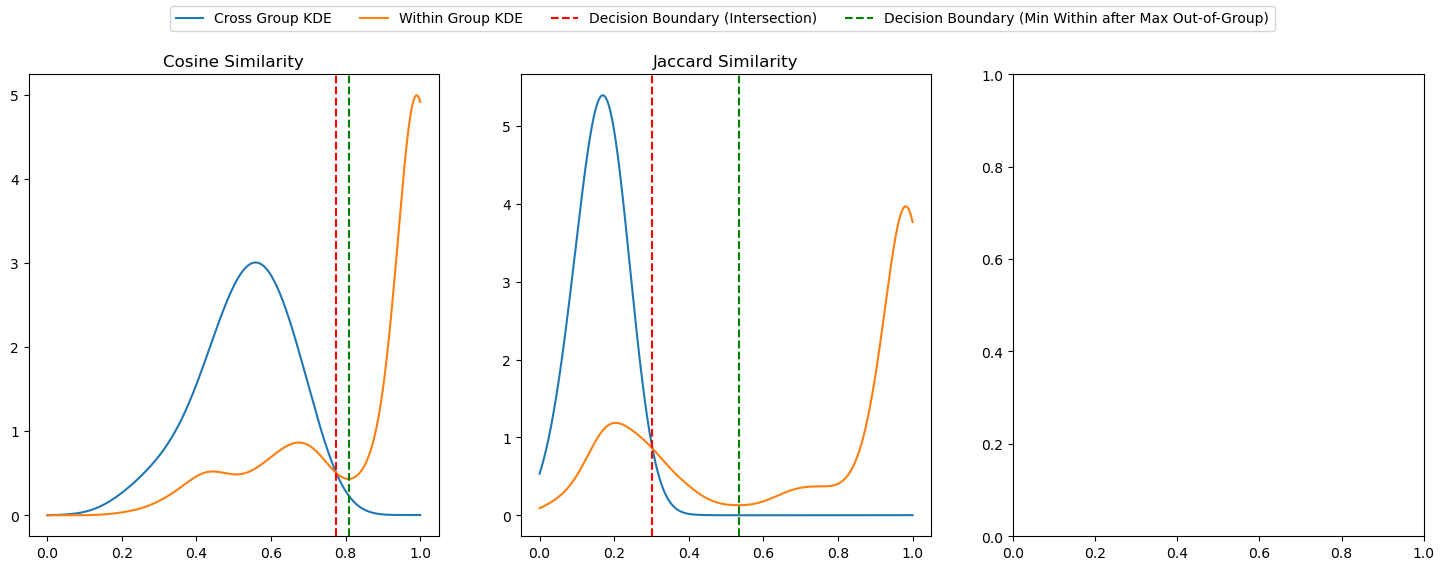

Estimated Decision Boundaries (Intersection):
Cosine: 0.77
Jaccard: 0.30

Estimated Decision Boundaries (Min Within after Max Out-of-Group):
Cosine: 0.81
Jaccard: 0.53


In [723]:


# Initialize the figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# List of similarity metrics
metrics = list(similarity_metrics.keys())

# Initialize dictionaries to store decision boundaries
decision_boundaries_1 = {}
decision_boundaries_2 = {}

# Generate values for plotting
x_values = np.linspace(0, 1, 1000).reshape(-1, 1)

for i, metric in enumerate(metrics):
    # Extract scores from the dfs dictionary
    cross_group_scores = dfs[f"{metric}_non_matching"]['score'].to_numpy()
    within_group_scores = dfs[f"{metric}_matching"]['score'].to_numpy()
    
    # Reshape data
    cross_group_array = np.array(cross_group_scores).reshape(-1, 1)
    within_group_array = np.array(within_group_scores).reshape(-1, 1)

    # Perform Kernel Density Estimation
    kde_non_matching = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(cross_group_array)
    kde_matching = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(within_group_array)

    # Get log probability densities and exponentiate
    log_dens_cross = kde_non_matching.score_samples(x_values)
    log_dens_within = kde_matching.score_samples(x_values)
    
    dens_cross = np.exp(log_dens_cross)
    dens_within = np.exp(log_dens_within)
    
    # Compute the differences between the densities
    diff = dens_cross - dens_within
    
    # Find points where the difference changes sign
    sign_changes = np.where(np.diff(np.sign(diff)))[0]
    
    # Choose the highest x-value among the sign changes for the decision boundary
    highest_sign_change_idx = sign_changes[-1]
    decision_boundary_value = x_values[highest_sign_change_idx]
    
    # Find maximum point in the cross-group density
    max_cross_idx = np.argmax(dens_cross)
    
    # Find minimum point in the within-group density after max_cross_idx
    min_within_idx = max_cross_idx + np.argmin(dens_within[max_cross_idx:])
    min_within_value = x_values[min_within_idx]

    # Store the decision boundary values in dictionaries
    
    decision_boundaries_1[metric] = decision_boundary_value
    decision_boundaries_2[metric] = min_within_value

    # Plotting
    axs[i].plot(x_values, dens_cross, label='Cross Group KDE')
    axs[i].plot(x_values, dens_within, label='Within Group KDE')
    axs[i].axvline(x=decision_boundary_value, color='r', linestyle='--', label='Decision Boundary (Intersection)')
    axs[i].axvline(x=min_within_value, color='g', linestyle='--', label='Decision Boundary (Min Within after Max Out-of-Group)')
    axs[i].set_title(f'{metric.capitalize()} Similarity')

# Initialize lists to hold handles and labels
handles, labels = [], []

# Collect handles and labels

ax = axs[i]
h, l = ax.get_legend_handles_labels()
handles.extend(h)
labels.extend(l)


# Create a single legend for the whole figure
fig.legend(handles, labels, loc='upper center', ncol=len(handles))

plt.show()

# Print both types of decision boundaries
print("Estimated Decision Boundaries (Intersection):")
for metric, boundary in decision_boundaries_1.items():
    print(f"{metric.capitalize()}: {boundary[0]:.2f}")

print("\nEstimated Decision Boundaries (Min Within after Max Out-of-Group):")
for metric, boundary in decision_boundaries_2.items():
    print(f"{metric.capitalize()}: {boundary[0]:.2f}")


### Find out which job id pairs are over the threshold

In [724]:
print(f"Number of within-group pairs which have a similarity score over the threshold (1st and 2nd method):")
for metric in metrics:
    threshold_1 = decision_boundaries_1[metric][0]
    count_1 = sum(score > threshold_1 for score in dfs[f'{metric}_matching'].score)
    
    threshold_2 = decision_boundaries_2[metric][0]
    count_2 = sum(score > threshold_2 for score in dfs[f'{metric}_matching'].score)
    print(f"{metric} similarity : {count_1}, {count_2}")


Number of within-group pairs which have a similarity score over the threshold (1st and 2nd method):
cosine similarity : 399, 393
jaccard similarity : 431, 381


In [725]:
for metric in metrics:
    threshold_1 = decision_boundaries_1[metric][0]
    over_threshold_1 = sum(score > threshold_1 for score in dfs[f'{metric}_matching'].score)
    
    threshold_2 = decision_boundaries_2[metric][0]
    count_2 = sum(score > threshold_2 for score in dfs[f'{metric}_matching'].score)

In [726]:

over_threshold_pairs_1 = {}
over_threshold_pairs_2 = {}
over_threshold_pairs = [over_threshold_pairs_1, over_threshold_pairs_2]

for metric in metrics:
    threshold_1 = decision_boundaries_1[metric][0]
    threshold_2 = decision_boundaries_2[metric][0]

    threshold_1_df = dfs[f'{metric}_matching'][dfs[f'{metric}_matching'].score > threshold_1][["index_1","index_2"]]
    threshold_2_df = dfs[f'{metric}_matching'][dfs[f'{metric}_matching'].score > threshold_2][["index_1","index_2"]]

    over_threshold_pairs_1[metric] = set(threshold_1_df.itertuples(index=False, name=None))
    over_threshold_pairs_2[metric] = set(threshold_2_df.itertuples(index=False, name=None))

### See how much the metrics overlap

In [727]:
df = pd.DataFrame(columns=['A', 'B', 'Difference'])

#loop through pairs of metrics
for metric1 in metrics:
    for metric2 in metrics:
        for i in range(2):
            for j in range(2):
                if metric1 != metric2 and metric1 > metric2 :
                    x = over_threshold_pairs[i][metric1]
                    y = over_threshold_pairs[j][metric2]
                    
                    # calculate difference between intersection and 
                    difference = min(len(x),len(y)) - len(x.intersection(y))
                    
                    df_single_row = pd.DataFrame({'A': [f"{metric1}_{i+1}"], 'B': [f"{metric2}_{j+1}"], 'Difference': [difference]})
                    df = pd.concat([df,df_single_row])


df.sort_values(by="Difference", inplace=True, ascending=False)
# Display the DataFrame
print(df.to_string(index=False))

        A        B Difference
jaccard_1 cosine_1          1
jaccard_2 cosine_1          1
jaccard_2 cosine_2          1
jaccard_1 cosine_2          0


Overall the metrics seem to have similar results, only Sequence Matcher paired witht he first decision boundary method had any relevant differences.


### Similarity Clusters

In [728]:
pairs_list = list(over_threshold_pairs_2['jaccard'])

G = nx.Graph()
G.add_edges_from(pairs_list)

num_duplicate_pairs = G.number_of_edges()

num_job_ids = G.number_of_nodes()


clusters = [list(c) for c in nx.connected_components(G)]

print(f"Number of clusters: {len(clusters)}")
print(f"Number of pairs: {num_duplicate_pairs}")
print(f"Number of distinct job_ids: {num_job_ids}")


Number of clusters: 243
Number of pairs: 381
Number of distinct job_ids: 551


In [729]:
for metric in metrics:
    threshold_1 = decision_boundaries_1[metric][0]
    count_1 = sum(score > threshold_1 for score in dfs[f'{metric}_matching'].score)
    
    threshold_2 = decision_boundaries_2[metric][0]
    count_2 = sum(score > threshold_2 for score in dfs[f'{metric}_matching'].score)
    
    
print(f"Number of within-group pairs which have a similarity score over the threshold (1st and 2nd method):")
for metric in metrics:
    print(f"{metric} similarity : {count_1}, {count_2}")

Number of within-group pairs which have a similarity score over the threshold (1st and 2nd method):
cosine similarity : 431, 381
jaccard similarity : 431, 381


### Delete duplicate jobs based on similar descriptions

In [730]:
rows_to_remove = []

for cluster in clusters:
    sorted_cluster = sorted(cluster)  # Sort to find the smallest element
    rows_to_remove.extend(sorted_cluster[1:])  # Exclude the smallest one

# Convert to a set if you want unique numbers
all_unique_nums_excluding_smallest_set = set(rows_to_remove)

# If you want it as a list
all_unique_nums_excluding_smallest_list = list(all_unique_nums_excluding_smallest_set)

print("List of all unique numbers excluding the smallest in each cluster:")
print(all_unique_nums_excluding_smallest_list)


List of all unique numbers excluding the smallest in each cluster:
[2056, 2059, 2061, 2062, 2078, 2080, 2084, 2087, 2104, 2112, 2126, 2127, 2128, 2130, 2134, 93, 2153, 2155, 2157, 2166, 2167, 2175, 2177, 2178, 2181, 2184, 2185, 2187, 163, 2222, 2237, 192, 2244, 197, 2250, 210, 2258, 211, 215, 2269, 2272, 2281, 2284, 239, 240, 2293, 2299, 2303, 2305, 2307, 2310, 2311, 263, 2314, 272, 2323, 2343, 300, 2352, 2367, 2369, 2379, 2380, 2395, 358, 2409, 2419, 381, 2440, 2459, 2463, 420, 421, 2470, 438, 443, 455, 2512, 2519, 475, 488, 489, 2543, 507, 2579, 2585, 2587, 550, 2607, 2618, 591, 592, 599, 2647, 608, 2659, 2669, 2676, 633, 652, 672, 2738, 705, 2754, 712, 750, 2803, 2806, 2814, 769, 2820, 780, 785, 788, 791, 794, 795, 803, 805, 815, 2879, 831, 837, 2886, 2888, 840, 2890, 2922, 875, 881, 882, 2932, 887, 889, 892, 895, 897, 914, 915, 921, 923, 938, 956, 962, 977, 982, 987, 1009, 1014, 1021, 1022, 1035, 1036, 1054, 1058, 1061, 1075, 1076, 1079, 1080, 1081, 1089, 1093, 1095, 1097, 1103, 11

### Duplicate removal complete!!!

In [731]:
jobs_df.schedule_type.value_counts()

schedule_type
Full–time                              1912
Contractor                               97
Part-time                                26
Internship                               14
Full–time and Temp work                  10
Full–time and Part-time                   8
Full–time and Contractor                  8
Temp work                                 7
Contractor and Temp work                  3
Full–time, Contractor and Temp work       3
Full–time, Part-time and Contractor       2
Temp work and Internship                  1
Part-time and Temp work                   1
Full–time and Internship                  1
Name: count, dtype: int64

# Extract Data From Descriptions 
Salary, years of experience, skills, responsibilities 

## Most common words

#### Most common words without removing general common words

In [732]:
df = cleaned_jobs_df 
df['tokenized_description'] = df['description'].apply(lambda x: list(set(x.split())))

# Step 3: Count Word Frequency
word_counter = Counter()
df['tokenized_description'].apply(lambda x: word_counter.update(x))

# Output the most common words and their counts
most_common_words = word_counter.most_common()

# Convert Counter to DataFrame for a table display
most_common_df = pd.DataFrame(word_counter.most_common(), columns=['Word', 'Count'])

# Display the first 100 rows
print(most_common_df.head(100))

             Word  Count
0              to   1962
1             and   1959
2             the   1945
3              in   1932
4               a   1925
5              of   1921
6            with   1893
7             for   1889
8            data   1828
9              is   1690
10           will   1636
11             on   1629
12           Data   1626
13             be   1619
14            are   1592
15             an   1547
16     experience   1515
17             as   1510
18             or   1501
19            you   1457
20              •   1451
21        working   1421
22           work   1373
23           team   1355
24           role   1314
25       business   1313
26           that   1312
27           this   1310
28            The   1276
29           from   1255
30           have   1248
31           your   1237
32            our   1219
33        Analyst   1216
34         skills   1214
35          their   1180
36     Experience   1136
37             We   1117
38             at   1107


#### Removing stop words and 1000 most popular words

In [733]:
# List of English stop words
stop_words = set(stopwords.words('english'))

# Get the list of words from Reuters
words = reuters.words()

# Create a frequency distribution
fdist = FreqDist(words)

# Get the 1000 most common words from Reuters and make them lowercase
common_words = set([word.lower() for word, frequency in fdist.most_common(1000)])


df = cleaned_jobs_df

# Text cleaning function
def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text).lower()  # Make text lowercase here

# Tokenize, clean text and remove duplicates
df['tokenized_description'] = df['description'].apply(lambda x: list(set(clean_text(x).split())))

# Count Word Frequency
word_counter = Counter()
df['tokenized_description'].apply(lambda x: word_counter.update([word for word in x if word not in stop_words and word not in common_words])) 

# Convert Counter to DataFrame
most_common_df = pd.DataFrame(word_counter.most_common(), columns=['Word', 'Count'])

# Display the first 100 rows
print(most_common_df.head(100))


                Word  Count
0         experience   1756
1               role   1572
2               team   1551
3            working   1529
4             skills   1495
5           analysis   1252
6             across   1067
7                sql   1034
8            ability   1034
9            looking    989
10         knowledge    988
11       opportunity    979
12             tools    969
13         analytics    947
14             teams    940
15              join    910
16      stakeholders    907
17      requirements    901
18             apply    890
19         reporting    856
20             using    844
21            please    842
22          insights    833
23  responsibilities    829
24           develop    803
25       environment    798
26        analytical    798
27                us    790
28     understanding    789
29     opportunities    781
30     communication    776
31         excellent    772
32               job    758
33          benefits    751
34           reports

## Extract skills from description

### Skills found in the table above 

Here are the skills which I found looking through the table:
SQL, Python, Excel, Power BI, Tableau, R, Microsoft, Google, Looker, Azure, cloud, AWS, PowerPoint

In [734]:
common_skills = ["sql", "python", "excel", "powerbi", "power bi", "tableau", "r", "microsoft", "google", "looker", "azure", "cloud", "aws", "powerpoint"]

# Filter most_common_df to only include industry-specific terms
skills_df = most_common_df[most_common_df['Word'].isin(common_skills)]

# Sort the DataFrame by frequency
skills_df = skills_df.sort_values(by='Count', ascending=False)

# Display the DataFrame
print(skills_df)

           Word  Count
7           sql   1034
36       python    722
49        excel    632
88      tableau    462
148           r    353
261       cloud    240
263   microsoft    240
271     powerbi    237
322      google    207
471      looker    150
481       azure    147
560         aws    131
880  powerpoint     81


In [735]:
# For "power bi" or "aws" (Amazon Web Services) or "google" (Google Cloud)
# I need to look at sequences of more than one word from the descriptions 
# I need to get those from cleaned_jobs_df  

### Extracting series of multiple words

In [736]:
import nltk
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def extract_ngrams(series, n=2):
    series = series.str.lower()    
    vectorizer = CountVectorizer(ngram_range=(n, n), lowercase=True)
    X = vectorizer.fit_transform(series)
    count_list = X.toarray().sum(axis=0) 
    ngrams_list = vectorizer.get_feature_names_out()
    ngrams_count = dict(zip(ngrams_list, count_list))
    return ngrams_count


In [737]:
ngram_counts = extract_ngrams(cleaned_jobs_df['description'])

desired_sequences = ["power bi", "amazon web services", "google cloud"]

for seq in desired_sequences:
    print(f"{seq}: {ngram_counts.get(seq, 0)}")


power bi: 752
amazon web services: 0
google cloud: 43


#### Investigate mentions of google in description 

In [738]:
google_ngrams = []

# Find what skills start with "Google"
for description in cleaned_jobs_df['description']:
    matches = re.findall(r'\bGoogle(?: [A-Z][a-z]*)*\b', description)
    google_ngrams.extend(matches)

# Get the lowercase unique sequences
google_ngrams_unique = list(set([x.lower() for x in google_ngrams]))

# Get the ngram counts in the descriptions
ngram_counts = Counter([x.lower() for x in google_ngrams])

# Create a dictionary with desired sequences and their counts
sequence_count_dict = {seq: ngram_counts.get(seq, 0) for seq in google_ngrams_unique}

# Sort the dictionary by counts in descending order
sorted_sequence_count_dict = {k: v for k, v in sorted(sequence_count_dict.items(), key=lambda item: item[1], reverse=True)}

# Print the sequences along with their counts
for seq, count in sorted_sequence_count_dict.items():
    print(f"{seq}: {count}")


google analytics: 116
google: 80
google cloud platform: 25
google sheets: 25
google data studio: 23
google cloud: 17
google tag manager: 16
google ads: 10
google marketing platform: 5
google suite: 3
google big query: 2
google data: 2
google drive: 2
google optimize: 2
google products: 2
google ad: 2
google marketing: 2
google workspace: 2
google my business: 2
google analytics individual qualification: 1
google advertising: 1
google partner: 1
google workplace: 1
google tagmanager: 1
google search console: 1
google big: 1
google studios: 1
google analytics strong: 1
google dataflow: 1


Here we see that the only skills starting with 'Google' which have a significant amount of mentions is "Google Analytics"

Lets add google analytics to our list of skills

In [739]:
# Add "google analytics" to skills list
common_skills.append('google analytics')
common_skills = list(set(common_skills))


### Add skills column to jobs table

In [740]:
import re

def find_common_skills(description):
    found_skills = set(list([skill for skill in common_skills if re.search(fr'\b{re.escape(skill)}\b', description, re.IGNORECASE)]))
    return found_skills

# Create a new column with the list of terms found in each description
cleaned_jobs_df['Skills'] = cleaned_jobs_df['description'].apply(find_common_skills)

# Now 'Skills' column in cleaned_jobs_df contains a list of terms from common_skills that are found in each description


In [741]:
skills_series = cleaned_jobs_df['Skills'].explode()
skills_count = skills_series.value_counts()
print(skills_count)

Skills
sql                 1061
python               768
excel                650
tableau              478
power bi             473
r                    399
cloud                268
powerbi              247
microsoft            241
google               217
looker               157
azure                149
aws                  137
google analytics     101
powerpoint            82
Name: count, dtype: int64


#### fix power bi

In [742]:
def replace_powerbi(skills_list):
    return list(set(['power bi' if skill.lower() == 'powerbi' else skill for skill in skills_list]))

cleaned_jobs_df['Skills'] = cleaned_jobs_df['Skills'].apply(replace_powerbi)


In [743]:
skills_series = cleaned_jobs_df['Skills'].explode()
skills_count = skills_series.value_counts()
print(skills_count)

Skills
sql                 1061
python               768
power bi             688
excel                650
tableau              478
r                    399
cloud                268
microsoft            241
google               217
looker               157
azure                149
aws                  137
google analytics     101
powerpoint            82
Name: count, dtype: int64


#### number of skills per job

In [744]:
# Create a new column with the number of skills per job
cleaned_jobs_df['Num_Skills'] = cleaned_jobs_df['Skills'].apply(len)

# Create a frequency table for the number of skills
skills_frequency_table = cleaned_jobs_df['Num_Skills'].value_counts().reset_index()

# Rename the columns for better understanding
skills_frequency_table.columns = ['Number_of_Skills', 'Number_of_Jobs']

# Sort the table by the number of skills for better visualization
skills_frequency_table = skills_frequency_table.sort_values(by='Number_of_Skills').reset_index(drop=True)

# Display the table without the index
print(skills_frequency_table.to_string(index=False))


 Number_of_Skills  Number_of_Jobs
                0             383
                1             239
                2             365
                3             345
                4             242
                5             189
                6             134
                7              57
                8              25
                9               5
               10               2
               11               1


In [745]:
# Filter the dataframe for rows with exactly 11 skills
jobs_with_14_skills = cleaned_jobs_df[cleaned_jobs_df['Num_Skills'] == 11]

# Display the description(s) of job(s) with 11 skills
for index, row in jobs_with_14_skills.iterrows():
    print(f"Index: {index}")
    print(f"Title: {row['title']}")
    print(f"Company Name: {row['company_name']}")
    print(f"Skills: {row['Skills']}")
    print("\n")
    print(f"Description:")
    print(row['description'])
    print('-'*50)  # Print a separator for readability


Index: 1621
Title: Data Analyst
Company Name: Landsec
Skills: ['sql', 'microsoft', 'excel', 'google', 'cloud', 'tableau', 'r', 'python', 'aws', 'power bi', 'azure']


Description:
Principle accountabilities

Building and Embedding Data and Analytics Products in a Commercial Environment
• Building data and analytics products (reports, dashboards, visualisations, analysis) and working with multiple internal / external stakeholders to drive business adoption and performance.
• Quickly build internal (business) and external (market) knowledge and assess new data and analytics opportunities (gathering ideas, research, carrying out analysis, refining and prioritising new requirements)
• Analyse and translate business needs into data models, ensuring that they meet the data standards required for these to be a reusable and long-term data asset for Landsec
• Measure impact, success and adoption using relevant metrics/KPIs, and use this to inform future enhancements of the data and analytics pr

### Jobs with no skills

In [746]:
### 252 jobs have no skills listed lets take a look at the most common words in the job descriptions from this subset
subset_no_skills = cleaned_jobs_df[cleaned_jobs_df['Num_Skills'] == 0]

#### most common words for jobs with no skills

In [747]:
# List of English stop words
stop_words = set(stopwords.words('english'))

# Get the list of words from Reuters
words = reuters.words()

# Create a frequency distribution
fdist = FreqDist(words)

# Get the 1000 most common words from Reuters and make them lowercase
common_words = set([word.lower() for word, frequency in fdist.most_common(1000)])

df = subset_no_skills

# Text cleaning function
def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text).lower()  # Make text lowercase here

# Tokenize, clean text and remove duplicates
df['tokenized_description'] = df['description'].apply(lambda x: list(set(clean_text(x).split())))

# Count Word Frequency
word_counter = Counter()
df['tokenized_description'].apply(lambda x: word_counter.update([word for word in x if word not in stop_words and word not in common_words])) 

# Convert Counter to DataFrame
most_common_df = pd.DataFrame(word_counter.most_common(), columns=['Word', 'Count'])

# Display the first 100 rows
print(most_common_df.head(1000))


                  Word  Count
0                 role    273
1           experience    260
2              working    239
3                 team    223
4               skills    203
5             analysis    184
6               across    162
7                apply    161
8          opportunity    152
9         requirements    151
10             looking    150
11                 job    147
12                join    145
13             ability    144
14              please    142
15           knowledge    126
16         information    125
17               teams    122
18              ensure    121
19    responsibilities    118
20        stakeholders    117
21             process    113
22           reporting    112
23       communication    110
24              client    110
25             quality    110
26              hybrid    109
27       understanding    109
28            required    108
29             develop    108
30         environment    108
31                  us    107
32        

/var/folders/52/f5r39c112rj3fmprfdv42nvh0000gn/T/ipykernel_18002/878812417.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_description'] = df['description'].apply(lambda x: list(set(clean_text(x).split())))


In [748]:
skills_series = cleaned_jobs_df['Skills'].explode()
skills_count = skills_series.value_counts()
print(skills_count)


Skills
sql                 1061
python               768
power bi             688
excel                650
tableau              478
r                    399
cloud                268
microsoft            241
google               217
looker               157
azure                149
aws                  137
google analytics     101
powerpoint            82
Name: count, dtype: int64


#### descriptions of jobs with no skills

In [749]:
for index, row in subset_no_skills.iterrows():
    print(f"Index: {index}")
    print(f"Title: {row['title']}")
    print(f"Company Name: {row['company_name']}")
    print(f"Skills: {row['Skills']}")
    print("\n")
    print(f"Description:")
    print(row['description'])
    print('-'*250)  # Print a separator for readability


Index: 12
Title: Data and Analytics Partner
Company Name: Public Sector Resourcing
Skills: []


Description:
Data and Analytics Partner - (Inside IR35)

Contract Term: 6 months

Contracting Authority: Bank of England

Location: Hybrid - 1 to 2 days a week in the London office / Remote Working

Please note that active SC Clearance is an essential requirement for this position

As a Data and Analytics Partner your main responsibilities will be
• Engage across data & analytics (D&A) services to understand work currently underway
• Bring together initial scope for enhanced D&A services such that structured and consistent delivery management is possible
• Work with defined stakeholders to scope the project to the stage that it either:

Goes on a service's backlog
• Is agreed with the business it is no longer needed or is not a suitable candidate for D&A support
• Goes into the funnel for our future delivery mechanism, if it requires multiple D&A services
• Creation of refinement framework (

Skills found in these descriptions:
SAS,
Power BI (immediately followed by another letter due to formatting issue)
Hadoop, Spark, NoSQL

# Salaries

#### Process

Make a function which extracts salary ranges from text <br>
Make a function which extracts single salary from text <br>
Make a function which formats salaries into a common format <br>
    - change K to thousands <br>
    - add column for payment period ( per day, per hour,.. etc.)


Count how many times does the pound sign appear in each description <br>
For each row where there is more than one, count distances between the pound signs <br>
For each row without a salary range try to find a single salary.<br>

First get salary from title.
Then from extensions.
Then from description.

If there is a salary found in previous section use that.

#### How many times does the pound symbol appear in each column 

In [871]:
count_pound_symbol = {col: cleaned_jobs_df[col].apply(lambda x: "£" in str(x)).sum() for col in cleaned_jobs_df.columns if cleaned_jobs_df[col].dtype == 'object'}

for column, count in count_pound_symbol.items():
    if count != 0:
        print(f"Column '{column}' contains the symbol '£' in {count} rows.")


Column 'title' contains the symbol '£' in 16 rows.
Column 'description' contains the symbol '£' in 700 rows.
Column 'extensions' contains the symbol '£' in 231 rows.


In [872]:
count_gbp_symbol = {col: cleaned_jobs_df[col].apply(lambda x: "GBP" in str(x)).sum() for col in cleaned_jobs_df.columns if cleaned_jobs_df[col].dtype == 'object'}

gbp_total_count = sum(count_gbp_symbol.values())
print(f"The symbol 'GBP' appears {gbp_total_count} times in the dataframe.")


The symbol 'GBP' appears 36 times in the dataframe.


In [873]:
count_pound_rows = sum(jobs_df.apply(lambda row: any("£" in str(cell) for cell in row), axis=1))

print(f"{count_pound_rows} rows contain at least 1 pound sign.")


870 rows contain at least 1 pound sign.


### Functions for extracting salaries

In [1181]:
def clean_salary(lst):
    '''
    takes in list of salaries and returns the corrected list, fixing missing or extra Ks
    typo (e.g.: £48,000K)
    identify missing 'k' and add where needed (e.g.: £30-£40K)
    replaces K by 000,
    replaces common formatting differences 

    '''
    cleaned_salaries = []
    for salary in lst:
        # Remove extra Ks
        if re.search(r'£\d{2,3},\d{3}[kK]', salary):
            salary = re.sub(r'[kK]', '', salary)
        
        # Add missing Ks
        if re.search(r'£\d{2,3}-£\d{2,3}[kK]', salary) or re.search(r'£\d{2,3}[kK]-£\d{2,3}', salary):
            parts = re.split(r'-', salary)
            if len(parts) == 2:
                if 'k' not in parts[0].lower():
                    parts[0] += 'k'
                if 'k' not in parts[1].lower():
                    parts[1] += 'k'
                salary = '-'.join(parts)
        
        # replace Ks by multiplying by 1000
        cleaned_salary = re.sub(r'(\d+\.?\d*)[kK]', lambda x: str(int(float(x.group(1)) * 1000)), salary) 
        
        # Fix common formatting differences
        cleaned_salary = re.sub(r"and|—|–|to", "-", cleaned_salary)
        cleaned_salary = re.sub(r" - | -|- ", "-", cleaned_salary)
        cleaned_salary = re.sub(r"," ,"", cleaned_salary)

        cleaned_salaries.append(cleaned_salary)


    return cleaned_salaries

In [955]:
def extract_salary_ranges(text):
    '''
    Given description, extracts the salary ranges and outputs a list 
    '''
    # A regex pattern to match salary ranges and the terms that may follow (like "per annum", "per month", etc.)
    pattern = r'£.{3,15}£[\d.,kK]+(?:\s+(?:/|per|a|an)\s+[\w,]+)?'

    matches = re.findall(pattern, text, flags=re.IGNORECASE)
    
    # Removing trailing commas and filtering the ranges
    salary_ranges_found = [match for match in matches] 

    return salary_ranges_found


In [ ]:
def extract_single_salaries(text):
    '''
    given description extracts single salary (non range)
    '''
    pattern = r'£[\d.,kK]+(?:\s*(?:-|/|per|a|an)\s*[\w,]+)?'
    matches = re.findall(pattern, text)
    
    # Filtering out ranges (those containing '-') and removing trailing comma
    single_salaries_found = []
    for match in matches:
        if '-' not in match:
            # Remove trailing comma, if present
            if match.endswith(','):
                match = match[:-1]
            single_salaries_found.append(match)
    
    return single_salaries_found

In [1223]:
def split_salary_range(lst):
    '''
    Splits time period from salary range, removes unwanted characters from first part
    '''
    new_lst = []
    
    for salary in lst:
        pattern = r'£.*£[\d.]+'
        match = re.search(pattern, salary)
        
        if match:
            first_part = salary[:match.end()]
            first_part = re.sub(r"[^£0-9.\-]", "", first_part) 
            
            if re.search(r'\d+£', first_part):
              continue

            second_part = salary[match.end():].lower().replace("per annum","per year") 
            
            if second_part == "":
                new_lst.append([first_part])
            
            else:
                new_lst.append([first_part, second_part])
        
        else:
            new_lst.append([salary])
    
    return new_lst


In [ ]:
def remove_broken_ranges(lst):
    '''
    '''
    new_lst = []
    for sublist in lst:
        if not any(re.search(r'\d+£', item) for item in sublist):
            new_lst.append(sublist)
    return new_lst

In [ ]:
def select_salary_range(lst):
    '''
    Takes list of salaries and returns the first salary and corresponding time
    period if there is the same salary with a time period further down the list.
    '''
    if lst == []:
        return []
    if len(lst[0]) !=1:
        return lst[0]
    
    salary = lst[0][0]
    for entry in lst:
        if entry[0] == salary and len(entry)>1:
            return entry
        
    return [salary]

In [ ]:
def clean_salary_time(lst):
    "takes in list of split salaries (salary, time period) and cleans up the time period"
    if len(lst) > 0:
        new_lst = []
        for x in lst:
            clean_time = ""
            if len(x) > 1:
                clean_time = re.sub("/|(a)(\s)|an","per\\2",x[1]).lstrip(" ")
                if clean_time[0:3] != "per":
                    new_lst.append ([x[0]])
                else:
                    new_lst.append ([x[0], clean_time])
        
        return new_lst
    return []

### Salaries in title

In [974]:
titles_w_pound = cleaned_jobs_df['title'][cleaned_jobs_df['title'].str.contains('£')]

# Display the titles containing the pound symbol
#print(titles_w_pound)


In [976]:
no_range_title = titles_w_pound.apply(lambda x: len(extract_salary_ranges(x)) ==0)
single_salary_title = titles_w_pound[no_range_title].apply(extract_single_salaries)

In [975]:
title_salary_range = titles_w_pound.apply(extract_salary_ranges)
#title_salary_range

### Salaries in extensions

#### convert extensions to lists

In [985]:
cleaned_jobs_df.loc[:, 'extensions'] = cleaned_jobs_df['extensions'].apply(lambda x: re.split(r'(?<!\d),(?!\d)', x))

#### Extract salary from extensions

In [949]:

salary_ext = cleaned_jobs_df['extensions'].apply(lambda x:[item for item in x if '£' in item])

# Remove rows where no salary ranges were found
salary_ext = salary_ext[salary_ext.apply(len) > 0]

# Display the newly created column
print(salary_ext.head())


8      [£500–£550 a day]
19         [£36K a year]
30    [£50K–£65K a year]
42    [£60K–£80K a year]
49    [£26K–£50K a year]
Name: extensions, dtype: object


Clean salary

In [762]:
clean_salary_ext = salary_ext.apply(clean_salary)

In [986]:
clean_salary_ext

19                  [£36000 a year]
30           [£50000-£65000 a year]
42           [£60000-£80000 a year]
49           [£26000-£50000 a year]
56           [£40000-£55000 a year]
107               [£300-£450 a day]
112          [£59000-£69000 a year]
131          [£40000-£60000 a year]
133          [£32500-£33000 a year]
138         [£95000-£105000 a year]
218          [£60000-£80000 a year]
225          [£32827-£40403 a year]
236          [£40000-£45000 a year]
277          [£35000-£45000 a year]
317          [£55000-£60000 a year]
422                 [£70000 a year]
424                   [£19 an hour]
433                 [£55000 a year]
445          [£50000-£70000 a year]
454          [£60000-£80000 a year]
458          [£60000-£75000 a year]
490                 [£32000 a year]
491          [£55000-£65000 a year]
505          [£45000-£55000 a year]
510          [£65000-£80000 a year]
512          [£65000-£75000 a year]
521          [£55000-£65000 a year]
523          [£65000-£85000 

#### split salary and payment period

Split for salary ranges and single salaries alike

In [987]:
def split_salary_time(lst):
    new_lst = []
    for s in lst:
        pattern = r'(£[\d.]+(?:\s*-\s*£[\d.]+)?)(.*)'
        match = re.match(pattern, s)
        if match:
            first_part = match.group(1).replace(",", "").strip()  # Capture the salary range or single salary
            second_part = match.group(2).lower()
            if second_part == "":
                new_lst.append([first_part])
            else:
                new_lst.append([first_part, second_part])
        else:
            new_lst.append([s])
    return new_lst

In [988]:
split_salary_ext = clean_salary_ext.apply(split_salary_time)
split_salary_ext

19                  [[£36000,  a year]]
30           [[£50000-£65000,  a year]]
42           [[£60000-£80000,  a year]]
49           [[£26000-£50000,  a year]]
56           [[£40000-£55000,  a year]]
107               [[£300-£450,  a day]]
112          [[£59000-£69000,  a year]]
131          [[£40000-£60000,  a year]]
133          [[£32500-£33000,  a year]]
138         [[£95000-£105000,  a year]]
218          [[£60000-£80000,  a year]]
225          [[£32827-£40403,  a year]]
236          [[£40000-£45000,  a year]]
277          [[£35000-£45000,  a year]]
317          [[£55000-£60000,  a year]]
422                 [[£70000,  a year]]
424                   [[£19,  an hour]]
433                 [[£55000,  a year]]
445          [[£50000-£70000,  a year]]
454          [[£60000-£80000,  a year]]
458          [[£60000-£75000,  a year]]
490                 [[£32000,  a year]]
491          [[£55000-£65000,  a year]]
505          [[£45000-£55000,  a year]]
510          [[£65000-£80000,  a year]]


The first function that I used was extract_extensions_salary().<br>
I have used functions clean_salary(), split_salary_time() above.<br>
I should unite these into one.<br>
Also I should use them below (except for extract_extensions_salary())<br>

## Salaries in Descriptions

### Salary Ranges

#### How many times does £ occur in each description
this can help determine if I'm capturing all the salary ranges 

Lets look at the subset of the jobs which have 2+ pounds signs and extract all the text between them to see how many of them are salary ranges


In [1183]:
pound_counts_desc = cleaned_jobs_df['description'].apply(lambda x: len(re.findall(r'£', x)))

print(pound_counts_desc.value_counts())

description
0     1856
1      467
2      444
3       82
4       64
6       19
5       10
7        6
9        2
16       2
8        1
12       1
10       1
Name: count, dtype: int64


In [1184]:
# indices of jobs_df which have 2+ pound signs:
two_plus_pounds = cleaned_jobs_df[pound_counts_desc >= 2]

# Print how many such rows
print("Number of rows with 2 or more pound signs:",len(two_plus_pounds))



Number of rows with 2 or more pound signs: 632


#### Rows with potential salary range

In [1185]:
# for each entry in two_or_more_pound_signs I want a list of distances (num of characters) between the pound signs, e.g. if a row has 5 pound signs, this will give me 4 numbers
def contains_salary_range(description):
    # Finding all the indices of pound signs
    indices = [m.start() for m in re.finditer('£', description)]
    
    # Finding the distances between consecutive pound signs
    distances = [indices[i + 1] - indices[i] for i in range(len(indices) - 1)]
    
    return any(3 <= distance <= 15 for distance in distances)

count_salary_ranges = two_plus_pounds['description'].apply(contains_salary_range).sum()

# Print the result
print(f"Number of rows with a potential salary range: {count_salary_ranges}")


Number of rows with a potential salary range: 459


#### Extract Salary Ranges

In [1186]:
salary_ranges_desc = two_plus_pounds['description'].apply(extract_salary_ranges)


#### Correct missing and extra Ks
Need to look for a special pattern where there is only one letter k

In [1187]:
# Look for entries with single "K"/"k"
entries_with_single_k = salary_ranges_desc[salary_ranges_desc.apply(lambda lst: any(len(re.findall(r'k', item, re.IGNORECASE)) == 1 for item in lst))]

print(entries_with_single_k)

155     [£50,000 - £55,000K per annum]
630     [£40,000k -£44,000 per annum,]
2371                        [£35-£45K]
2383                        [£35-£45K]
3236              [£40,000 - £48,000K]
3238              [£40,000 - £48,000K]
Name: description, dtype: object


#### Clean salary

In [1188]:
salary_ranges_desc[entries_with_single_k.index]

155     [£50,000 - £55,000K per annum]
630     [£40,000k -£44,000 per annum,]
2371                        [£35-£45K]
2383                        [£35-£45K]
3236              [£40,000 - £48,000K]
3238              [£40,000 - £48,000K]
Name: description, dtype: object

In [1191]:

clean_salary_ranges_desc = salary_ranges_desc.apply(clean_salary)
clean_salary_ranges_desc[entries_with_single_k.index]

155     [£50000-£55000 per annum]
630     [£40000-£44000 per annum]
2371              [£35000-£45000]
2383              [£35000-£45000]
3236              [£40000-£48000]
3238              [£40000-£48000]
Name: description, dtype: object

In [1211]:
clean_salary_ranges_desc[clean_salary_ranges_desc.apply(len)>1]

2                 [£35-£37, £35000.00-£37000.00 per year]
82                         [£40000-£50000, £40000-£50000]
113                [£250-£300 per day, £250-£300 per day]
118                        [£40000-£60000, £40000-£60000]
147                        [£68000-£80000, £68000-£80000]
212                        [£80000-£90000, £80000-£90000]
264                      [£80000-£110000, £80000-£110000]
276                        [£34000-£38000, £30000-£36000]
297              [£65000-£75000, £65000-£75000 per annum]
306         [£45000-£55000, £45000-£55000, £45000-£55000]
374         [£50000-£60000, £50000-£60000, £50000-£60000]
384              [£45000-£55000 per annum, £45000-£55000]
385                        [£45000-£55000, £45000-£55000]
459         [£50000-£60000, £50000-£60000, £50000-£60000]
524                        [£60000-£80000, £60000-£80000]
564                        [£55000-£65000, £55000-£65000]
565                        [£55000-£65000, £55000-£65000]
566           

I want to take the first salary range because I think that it is more likely to be the correct salary range (I've seen job postings with similar jobs linked below) <br>
However here I also see instances where we have the same salary appear more than once but the second time around it comes with the time period (e.g. "per day") <br>
I need to come up with a function which takes the first salary range and then if there is the same salary range but with time period then it takes the payment period too. <br>First I must split the salary range and payment periods

#### split salary and payment period
#### remove everything which is not a pound, numeric or "-" from the first part

In [1221]:
split_salary_ranges_desc = clean_salary_ranges_desc.apply(split_salary_range)

split_salary_ranges_desc[clean_salary_ranges_desc.apply(lambda x: len(x))>1]

2           [[£35-£37], [£35000.00-£37000.00,  per year]]
82                     [[£40000-£50000], [£40000-£50000]]
113        [[£250-£300,  per day], [£250-£300,  per day]]
118                    [[£40000-£60000], [£40000-£60000]]
147                    [[£68000-£80000], [£68000-£80000]]
212                    [[£80000-£90000], [£80000-£90000]]
264                  [[£80000-£110000], [£80000-£110000]]
276                    [[£34000-£38000], [£30000-£36000]]
297         [[£65000-£75000], [£65000-£75000,  per year]]
306     [[£45000-£55000], [£45000-£55000], [£45000-£55...
374     [[£50000-£60000], [£50000-£60000], [£50000-£60...
384         [[£45000-£55000,  per year], [£45000-£55000]]
385                    [[£45000-£55000], [£45000-£55000]]
459     [[£50000-£60000], [£50000-£60000], [£50000-£60...
524                    [[£60000-£80000], [£60000-£80000]]
564                    [[£55000-£65000], [£55000-£65000]]
565                    [[£55000-£65000], [£55000-£65000]]
566           

#### Remove broken salary ranges
Count occurrences of digits followed by pound
make function to remove those. If it is the only entry in that row then just remove anything starting from the pound, these will be used for the non-range salaries.

In [1222]:
def find_broken_range(lst):
    for sublist in lst:
        for item in sublist:
            if re.search(r'\d+£', item):
                return lst
    return []

matches = split_salary_ranges_desc.apply(find_broken_range)
matches[matches.apply(len)>0]


Series([], Name: description, dtype: object)

In [1210]:
split_salary_ranges_desc

1                                         [[40000-60000]]
2               [[35-37], [35000.00-37000.00,  per year]]
8                                        [[92970-108465]]
9                                                      []
16                                                     []
17                                                     []
20                               [[51000-66000,  a year]]
25                       [[45000.00-50000.00,  per year]]
26                                       [[90000-110000]]
30                                  [[250-300,  per day]]
33                                                     []
36                             [[55000-65000,  per year]]
38                             [[35000-40000,  per year]]
43                                        [[35000-42000]]
58                                        [[32000-40000]]
62                                        [[30500-41233]]
64                                                     []
74            

I want to see what was before the second pound sign in the ranges where it is broken

In [1085]:
salary_ranges_desc[matches.apply(len)>0]

52         [£600 / day + £50 / day]
1949                   [£25k + £5k]
1978    [£26,416 / £12.70 per hour]
2006    [£26,416 / £12.70 per hour]
2025                   [£25k + £5k]
2057    [£600-£650, £600/day + £50]
2082    [£26,416 / £12.70 per hour]
2145    [£26,416 / £12.70 per hour]
2209             [£29,475 (£33,500]
2777    [£40,000 £55,000 Per Annum]
Name: description, dtype: object

none of these are salary ranges so can be safely removed 

In [1086]:
clean_salary_ranges_desc_2 = split_salary_ranges_desc.apply(remove_broken_ranges)

clean_salary_ranges_desc_2[matches.apply(len)>0]

52                 []
1949               []
1978               []
2006               []
2025               []
2057    [[£600-£650]]
2082               []
2145               []
2209               []
2777               []
Name: description, dtype: object

#### Select salary range from list
Now here I will make the function which takes the first salary and looks for the same salary but with payment period

In [1161]:
clean_ranges = clean_salary_ranges_desc_2.apply(clean_salary_time).explode().dropna()
clean_ranges[clean_ranges.apply(len)>1].apply(lambda x: x[1]).value_counts()

description
per year     72
per day      15
per hour      3
per month     1
Name: count, dtype: int64

In [1163]:
clean_salary_ranges_desc_2.apply(select_salary_range)[clean_salary_ranges_desc_2.apply(len)>1]
clean_salary_ranges_desc_3 = clean_salary_ranges_desc_2.apply(select_salary_range)

In [1166]:
clean_salary_ranges_desc_3[clean_salary_ranges_desc_3.apply(len)>1].apply(lambda x: x[1]).value_counts()

description
 per year          58
 per day           14
 / year             6
 per hour           2
\na high            1
\n\na leading       1
\n\nan exciting     1
 per month          1
 an hour            1
 a year             1
 a day              1
Name: count, dtype: int64

In [1012]:
clean_salary_ranges_desc_3 = clean_salary_ranges_desc_3[clean_salary_ranges_desc_3.apply(len) > 0]


### single salary

Here I need to index all the rows not included above but which contain a pound sign

In [795]:
#Get all descriptions not included in the salary ranges
no_salary_range_desc = cleaned_jobs_df['description'].drop(clean_salary_ranges_desc_3.index)


#count how many times does the £ sign appear in each of these rows:
# Apply the function to the 'description' column to count occurrences of "£" in each description
pound_counts = no_salary_range_desc.apply(count_pounds)

# Print the results
print(pound_counts.value_counts())

description
0    1287
1     284
2      93
3      20
5       1
6       1
Name: count, dtype: int64


In [796]:

# Use the apply function on your series
single_salary_desc2 = no_salary_range_desc.apply(extract_single_salaries)

#### Clean single salaries


In [797]:
clean_single_salary_desc=single_salary_desc.apply(clean_salary)
clean_single_salary_desc[clean_single_salary_desc.apply(len)>0]

2                                                [£45000]
4                                           [£1.258, £85]
5                                          [£530 per day]
18                                               [£36500]
20                                               [£60000]
21                                                [£2.35]
28                                             [£375/day]
32                                                    [£]
34                                                  [£44]
36                                               [£65000]
47                             [£75000, £75000 per annum]
50                                            [£50, £600]
60                                                 [£1.9]
62                                               [£37000]
65                                                    [£]
73                                                  [£41]
79                                [£4500., £50000, £1000]
81            

#### split salary and payment period

In [798]:
def split_single_salary(lst):
    new_lst = []
    for s in lst:
        pattern = r'£[\d.]+'
        match = re.search(pattern, s)
        if match:
            first_part = s[:match.end()]
            # Remove unwanted characters from the first part
            first_part = re.sub(r'[^£\d-](.\d{2})', '', first_part)
            
            second_part = s[match.end():].lower().replace("per annum","per year").replace("/", "per ")
            if second_part == "":
                new_lst.append([first_part])
            else:
                new_lst.append([first_part, second_part])
        else:
            new_lst.append([s])
    return new_lst


In [799]:
split_single_salary_desc = clean_single_salary_desc.apply(split_single_salary)
split_single_salary_desc[split_single_salary_desc.apply(len)>0]

2                                              [[£45000]]
4                                           [[£1], [£85]]
5                                      [[£530,  per day]]
18                                             [[£36500]]
20                                             [[£60000]]
21                                              [[£2.35]]
28                                      [[£375, per day]]
32                                                  [[£]]
34                                                [[£44]]
36                                             [[£65000]]
47                        [[£75000], [£75000,  per year]]
50                                        [[£50], [£600]]
60                                               [[£1.9]]
62                                             [[£37000]]
65                                                  [[£]]
73                                                [[£41]]
79                          [[£4500.], [£50000], [£1000]]
81            

I'm seeing a lot of odd salaries here.
The overwhelming majority of the salaries here don't have a time period which is ok if its a 5-6 digit salary.
But what is the meaning of all these 2-3 digit salaries.
Lets take a look at the rows with a 2 or three digit salary.

In [800]:
mask = split_single_salary_desc.apply(lambda x: len(x[0][0]) <= 4 if x and x[0] and len(x[0]) == 1 else False)


no_salary_range_desc[mask].apply(lambda s : re.findall(r'£.{0,15}', s))

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

"/" used instead of per sometimes 
there are still salary ranges here
"£80 - 100K" missing pound sign and missing "K"
"£60, 000" space between comma and digits

look for ___ plus ___

In [ ]:
single_salary_desc.loc[2390]

['£75,000']

#### There could still be salary ranges here.
I noticed things such as "£55-77k" or "£60,000-70,000". I need to look for salary ranges which contain only one pound sign

In [ ]:
# Lets extract a list of salaries for each job in single_salary_df

# Final work for salaries (START HERE)

Optimise functions, make a couple which work for all sections
Convert salaries to numbers.


Add column to cleaned_data_df which has the salary, or salary range columns (min and max)
First take from title, then extensions, then description,
Add column for where the salary was taken from.
Normalise monthly/hourly salaries. (add column for normalised salary)

## Extract years of experience

#### How many rows have the words "year", "experience"

In [ ]:
# how many rows contain the word "experience"
experience_count = cleaned_jobs_df['description'].str.contains(r'\bexperience\b', case=False, na=False).sum()
print(f"The number of rows that contain the word 'experience': {experience_count}")


# how many rows contain the word "year"/"years"
year_count = cleaned_jobs_df['description'].str.contains(r'\byears?\b', case=False, na=False).sum()
print(f"The number of rows that contain the word 'year' or 'years': {year_count}")


# how many rows contain both "experience" and "year"/"years"

The number of rows that contain the word 'experience': 1699
The number of rows that contain the word 'year' or 'years': 850


In [ ]:
# Creating a mask that identifies rows containing the word "experience"
experience_mask = cleaned_jobs_df['description'].str.contains(r'\bexperience\b', case=False, na=False)

# Creating a mask that identifies rows containing the word "year" or "years"
year_mask = cleaned_jobs_df['description'].str.contains(r'\byears?\b', case=False, na=False)

# Finding the intersection of both masks to identify rows that contain both "experience" and "year"/"years"
both_words_mask = experience_mask & year_mask

# Counting the number of rows that satisfy the condition
both_words_count = both_words_mask.sum()

# Printing the result
print(f"The number of rows that contain both 'experience' and 'year'/'years': {both_words_count}")

The number of rows that contain both 'experience' and 'year'/'years': 806


#### Extract excerpts with the word experience

In [ ]:
# Custom function to extract context around the word "experience"
def extract_context(description):
    pattern = r'.{0,20}\bexperience\b.{0,20}'
    matches = re.findall(pattern, description, re.IGNORECASE)
    return matches

# Applying the function to the 'description' column
cleaned_jobs_df['experience_context'] = cleaned_jobs_df['description'].apply(extract_context)

# If you want to create a new dataframe with these contexts, you can do so as:
experience_context_df = cleaned_jobs_df['experience_context']

# To display the first few rows:
print(experience_context_df)


0                                                      []
1       [ic recommendations. Experience required:, Ana...
2       [ed Marketing Agency experience is required fo...
3       [r day, depending on experience.,  have the fo...
4       [red to your driving experience, no matter whe...
5       [Commercial experience in tooling such as , Ex...
6       [• Knowledge & Experience Requirements, • Expe...
7       [Knowledge and Experience, • Experience with S...
8       [- Proven experience in applying data an, - Ex...
9       [• 1-2 years of experience in data analytics i...
10      [ SQL, with hands-on experience to a high leve...
11      [Experience, hnology procurement experience an...
12      [ou have... previous experience in problem sol...
13      [• Proven experience as a Data Analyst o, • Ex...
14      [prove their members experience. Primarily own...
15      [Do you have experience of Business Data An, P...
16      [• BA with Agile experience (breaking out Epic...
17      [• You

In [ ]:
def extract_year_experience_context(description):
    #pattern = r'\byears?.*\bexperience\b'
    #pattern = r'\b(?:year.*experience|experience.*year)\b'
    pattern = r'(year.*experience|experience.*year)'
    matches = re.findall(pattern, description, re.IGNORECASE)
    return matches


# Applying the function to the 'description' column
cleaned_jobs_df['year_experience_context'] = cleaned_jobs_df['description'].apply(extract_year_experience_context)

# Filtering the DataFrame to only include rows with at least one match
filtered_df = cleaned_jobs_df[cleaned_jobs_df['year_experience_context'].apply(lambda x: len(x) > 0)]

# Now, to create a new DataFrame which only contains the snippets (excluding rows with no matches):
year_experience_context_df = filtered_df['year_experience_context']

# To display the first few rows:
print(len(year_experience_context_df))



487


#### count distances between the words "years" and "experience"

In [ ]:
def count_distance(description):
    year_indices = [m.start() for m in re.finditer(r'\byears?\b', description, re.IGNORECASE)]
    experience_indices = [m.start() for m in re.finditer(r'\bexperience\b', description, re.IGNORECASE)]
    
    if not year_indices or not experience_indices:
        return None

    min_distance = min(abs(y - e) for y in year_indices for e in experience_indices)
    return min_distance

# Apply the function to the 'description' column
cleaned_jobs_df['year_experience_distance'] = cleaned_jobs_df['description'].apply(count_distance)

# Now, you can analyze this new column to get insights into the distance between occurrences of "year"/"years" and "experience"
#cleaned_jobs_df['year_experience_distance'].dropna()


In [ ]:
def find_consecutive_distances(description):
    all_indices = [(m.start(), 'y') for m in re.finditer(r'\byears?\b', description, re.IGNORECASE)]
    all_indices += [(m.start(), 'e') for m in re.finditer(r'\bexperience\b', description, re.IGNORECASE)]
    
    # Sort all_indices by the indices, so that they appear in the order they occur in the text
    all_indices.sort(key=lambda x: x[0])
    
    distances = []
    for i in range(1, len(all_indices)):
        if all_indices[i][1] != all_indices[i-1][1]:  # If consecutive occurrences are of different words
            distances.append(all_indices[i][0] - all_indices[i-1][0])
    
    # Sorting the distances list
    distances.sort()
    return distances

# Apply the function to the 'description' column
cleaned_jobs_df['consecutive_distances'] = cleaned_jobs_df['description'].apply(find_consecutive_distances)

# Filter the series to exclude rows with empty lists and then print it
non_empty_distances = cleaned_jobs_df['consecutive_distances'][cleaned_jobs_df['consecutive_distances'].apply(len) > 0]
print(non_empty_distances)


4                                                    [56]
6                                  [8, 8, 9, 40, 61, 307]
9                                                     [9]
11                                              [16, 203]
13                                                  [845]
14                                              [68, 993]
22                                               [9, 468]
23                                              [10, 442]
24                                                    [7]
25                                               [9, 126]
26                                                 [2655]
28                                               [9, 315]
32                                                    [9]
37                                               [9, 129]
43                                      [253, 1131, 1565]
46                                             [239, 419]
48                                                  [608]
61            

In [ ]:
# Sorting the non_empty_distances series based on the first element of each list
non_empty_distances = non_empty_distances.apply(sorted)
sorted_non_empty_distances = non_empty_distances.sort_values(key=lambda x: x.str[0])

# Displaying the first few elements to check the result
print(sorted_non_empty_distances)


676                                          [5, 7, 1073]
1707                                                  [5]
897                                             [5, 1370]
1658                              [6, 6, 6, 33, 80, 1086]
888                                                   [6]
2793                                                  [6]
1394                                              [6, 33]
2856                                             [6, 184]
2786                                                  [6]
2460                                                  [6]
121                                             [6, 3313]
123                                               [6, 29]
1150                                                  [6]
833                                              [6, 590]
142                                         [6, 125, 288]
819                                              [6, 123]
2267                                       [6, 337, 1361]
573           

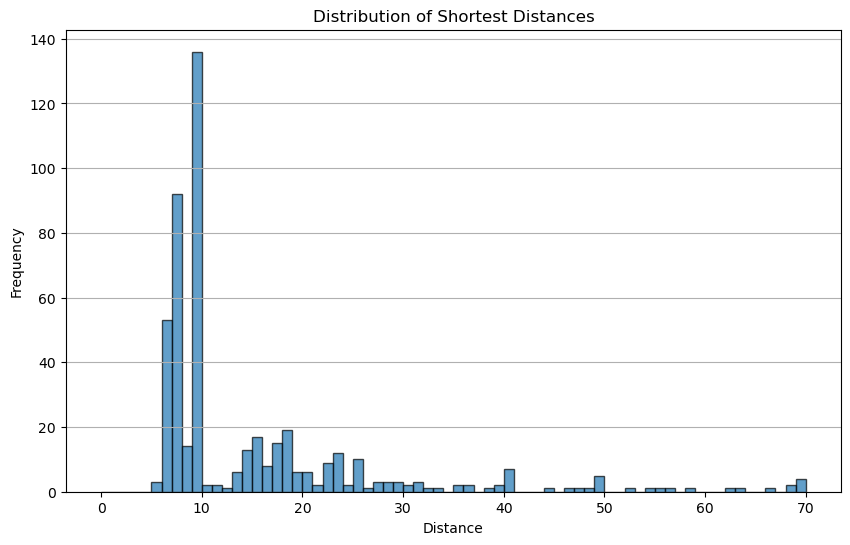

In [ ]:
# Step 1: Extract the shortest distances
shortest_distances = non_empty_distances.apply(lambda x: min(x) if x else None)

# Step 2: Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(shortest_distances.dropna(), bins=70, range=[0, 70], edgecolor='k', alpha=0.7)
plt.title('Distribution of Shortest Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()


#### extract patterns

In [ ]:
def extract_year_experience_snippets(description):
    pattern = r'\b(years?)([^a-zA-Z]+experience\b)'
    matches = re.findall(pattern, description, re.IGNORECASE)
    return [" ".join(match) for match in matches]

# Applying the function to the 'description' column to create a new column with the snippets
cleaned_jobs_df['year_experience_snippets'] = cleaned_jobs_df['description'].apply(extract_year_experience_snippets)

# Creating a new series with non-empty lists of snippets
non_empty_snippets = cleaned_jobs_df['year_experience_snippets'][cleaned_jobs_df['year_experience_snippets'].apply(len)> 0]

# Displaying the non-empty snippets
print(non_empty_snippets)


24                                   [years ' experience]
78                                   [years ' experience]
92                                    [years  experience]
98                                   [years ’ experience]
121                                   [years  experience]
123                                   [years  experience]
142                                   [years  experience]
189                                  [years ' experience]
210              [years ' experience, years ' experience]
230                                  [years ' experience]
263                                   [years  experience]
265                                  [years ' experience]
290                                  [years ' experience]
340                                  [years ' experience]
344                                  [years ' experience]
348                                  [years ' experience]
377                                   [years  experience]
385           

# EDA

In [ ]:
jobs_df['title'].value_counts()[0:5]

title
Data Analyst             411
Senior Data Analyst      128
Data Scientist            38
Business Data Analyst     27
HR Data Analyst           27
Name: count, dtype: int64

In [ ]:
jobs_df['schedule_type'].value_counts()

schedule_type
Full–time                              1852
Contractor                               93
Part-time                                26
Internship                               14
Full–time and Temp work                   8
Full–time and Part-time                   6
Temp work                                 5
Full–time and Contractor                  5
Contractor and Temp work                  3
Full–time, Contractor and Temp work       3
Full–time, Part-time and Contractor       2
Temp work and Internship                  1
Part-time and Temp work                   1
Full–time and Internship                  1
Name: count, dtype: int64

In [ ]:
jobs_df['via'].value_counts()[0:5]


via
via BeBee          561
via LinkedIn       316
via Recruit.net    159
via Talent.com      84
via Jobijoba UK     77
Name: count, dtype: int64

#### Number of jobs by job_board

In [ ]:
top_10_boards = cleaned_jobs_df['via'].value_counts()[0:10]

n_jobs_top_10_boards = sum(cleaned_jobs_df['via'].value_counts()[0:10])
n_jobs_total = sum(cleaned_jobs_df['via'].value_counts())
non_top_10 = n_jobs_total - n_jobs_top_10_boards


list_s = top_10_boards.tolist()
list_s.append(non_top_10)
top_10_boards = pd.Series(list_s, index=list(top_10_boards.index) + ['Other'])

top_10_boards

via BeBee              524
via LinkedIn           306
via Recruit.net        134
via Talent.com          79
via reed.co.uk          74
via Glassdoor           71
via Jobijoba UK         68
via Jobs                54
via Totaljobs           44
via Star Job Search     40
Other                  523
dtype: int64

In [ ]:
for index, row in subset_no_skills.iterrows():
    print(f"Index: {index}")
    print(f"Title: {row['title']}")
    print(f"Company Name: {row['company_name']}")
    print(f"Skills: {row['Skills']}")
    print("\n")
    print(f"Description:")
    print(row['description'])
    print('-'*250)  # Print a separator for readability


Index: 14
Title: Salesforce Data Analyst
Company Name: Lawrence Harvey
Skills: []


Description:
Salesforce Data Analyst:

The UK's largest union are undergoing a period of modernisation and transformation (3-5 year plan), leveraging digital development to improve their members experience. Primarily owning Salesforce, but also being responsible for data more broadly, you'll play an integral role in understanding members and making informed decisions that better respond to their needs and views.

Core role responsibilities include:
• Owning the Salesforce platform, keeping all member records up to date.
• Working alongside a Salesforce partner to maintain and further enhance the existing Org.
• Processing data to ensure it is accurate and in accordance with GDPR regulations.
• Development and maintenance of reporting systems for digital campaigns (including FormAssembly).

The successful applicant will be expected to have:
• A deep understanding of Salesforce - able to administer and co

idea: scan for bouroughs of london

scan for #days in office